<a href="https://colab.research.google.com/github/LargeMangoFromTheCave/JetBrains_Internship/blob/main/Gym_Mountain_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Создаём среду 

In [1]:
import gym
env = gym.make("MountainCar-v0")

Подключаем необходимые бииблиотеки для НС, работы с данными, времени

In [2]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import time
import copy
import random


In [3]:

device = torch.device("cuda")
def create_new_model():
    model = nn.Sequential(
        nn.Linear(2, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 3)
    )
    target_model = copy.deepcopy(model)
    
    #Загружаем модель на устройство, определенное в самом начале (GPU или CPU)
    model.to(device)
    target_model.to(device)
    
    #Сразу зададим оптимизатор, с помощью которого будем обновлять веса модели
    optimizer = optim.Adam(model.parameters(), lr=0.00003)
    
    return model, target_model, optimizer

In [4]:
gamma = 0.99
def fit(batch, model, target_model, optimizer):
    state, action, reward, next_state, done = batch
    # Загружаем батч на выбранное ранее устройство
    state = torch.tensor(state).to(device).float()
    next_state = torch.tensor(next_state).to(device).float()
    reward = torch.tensor(reward).to(device).float()
    action = torch.tensor(action).to(device)
    done = torch.tensor(done).to(device)

    # Считаем то, какие значения должна выдавать наша сеть
    target_q = torch.zeros(reward.size()[0]).float().to(device)
    with torch.no_grad():
        # Выбираем максимальное из значений Q-function для следующего состояния
        target_q = target_model(next_state).max(1)[0].view(-1) 
        target_q[done] = 0
    target_q = reward + target_q * gamma

    # Текущее предсказание
    q = model(state).gather(1, action.unsqueeze(1))

    loss = F.mse_loss(q, target_q.unsqueeze(1))

    # Очищаем текущие градиенты внутри сети
    optimizer.zero_grad()
    # Применяем обратное распространение  ошибки
    loss.backward()
    # Ограничиваем значения градиента. Необходимо, чтобы обновления не были слишком большими
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    # Делаем шаг оптимизации
    optimizer.step()

In [5]:
def select_action(state, epsilon, model):
    if random.random() < epsilon:
        return random.randint(0, 2)
    return model(torch.tensor(state).to(device).float().unsqueeze(0))[0].max(0)[1].view(1, 1).item()

In [6]:
class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, element):
        """Сохраняет элемент в циклический буфер"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Возвращает случайную выборку указанного размера"""
        return list(zip(*random.sample(self.memory, batch_size)))
    
    def __len__(self):
        return len(self.memory)

In [27]:
#Количество обновлений model между обновлениями target model
target_update = 1000
#Размер одного батча, который на вход принимает модель
batch_size = 128
#Количество шагов среды
max_steps = 100001
#Границы коэффициента exploration
max_epsilon = 0.5
min_epsilon = 0.1

def train():
      #Создаем модель и буфер
      memory = Memory(5000)
      model, target_model, optimizer = create_new_model()
      rewards_by_target_updates = []

      for step in range(max_steps):
            state = env.reset()
            #Делаем шаг в среде
            epsilon = max_epsilon - (max_epsilon - min_epsilon)* step / max_steps
            action = select_action(state, epsilon, model)
            new_state, reward, done, _ = env.step(action)
            #modified_reward = reward + 10 * abs(new_state[1])
            modified_reward = reward + 300 * (gamma * abs(new_state[1]) - abs(state[1]))

            #Запоминаем опыт и, если нужно, перезапускаем среду
            memory.push((state, action, modified_reward, new_state, done))
            #memory.push((state, action, reward, new_state, done))
            if done:
                  state = env.reset()
                  done = False
            else:
                  state = new_state

            #Градиентный спуск
            if step > batch_size:
                 fit(memory.sample(batch_size), model, target_model, optimizer)

            if step % target_update == 0:
                  target_model = copy.deepcopy(model)
      
                  #Exploitation
                  state = env.reset()
                  total_reward = 0
                  while not done:
                        action = select_action(state, 0, target_model)
                        state, reward, done, _ = env.step(action)
                        #modified_reward = reward + 300 * (gamma * abs(new_state[1]) - abs(state[1]))
                        total_reward += modified_reward

                  done = False
                  state = env.reset()
                  rewards_by_target_updates.append(total_reward)
      return rewards_by_target_updates

In [28]:
%%time
Rewards = train()

CPU times: user 4min 21s, sys: 5.65 s, total: 4min 26s
Wall time: 4min 29s


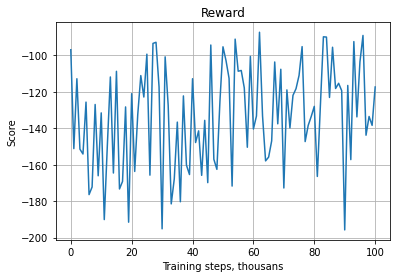

In [29]:
import matplotlib.pyplot as plt
# Plot Rewards
plt.plot((np.arange(len(Rewards))), Rewards)
plt.xlabel('Training steps, thousans')
plt.ylabel('Score')
plt.title('Reward')
plt.grid(True)
plt.show()